In [46]:
import json
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Origin", "Faulty engine", 'Fixed by', "Size"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['origin'],
        metadata['engine'],
        metadata['fixed-by'],
        data['metadata']['code-size'],
        # metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[4] if isinstance(row[4], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, intfmt=",", tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
print(f"Number of eval set: {len(table_data)}")
rq1_table_path = f'./table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    print(latex_table)
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

Number of eval set: 28
\begin{tabular}{llllr}
\hline
 Name            & Origin        & Faulty engine    & Fixed by    &      Size \\
\hline
 wasmedge\#3018   & WASMaker      & wasmedge-96ecb67 & 0.14.0-rc.5 &     1,913 \\
 wamr\#2789       & WASMaker      & wamr-0b0af1b     & 718f06      &    17,604 \\
 wasmedge\#3019   & WASMaker      & wasmedge-96ecb67 & 0.14.0-rc.5 &    19,098 \\
 wamr\#2862       & WASMaker      & wamr-7308b1e     & 0ee5ff      &    19,727 \\
 wamr\#2450       & WASMaker      & wamr-0b0af1b     & e360b7      &    24,482 \\
 wasmedge\#3076   & WASMaker      & wasmedge-96ecb67 & 0.14.0-rc.4 &    31,365 \\
 mandelbrot      & Wasm-R3-Bench & wizard-0d6926f   & 0b43b8      &    64,515 \\
 pathfinding     & Wasm-R3-Bench & wizard           & ccf0c56     &   180,026 \\
 pacalc          & Wasm-R3-Bench & wizard           & 81555ab     &   238,902 \\
 wasmedge\#3057   & WASMaker      & wasmedge-96ecb67 & 0.14.0-rc.4 &   243,564 \\
 guiicons        & Wasm-R3-Bench & wizard-

Wasm Reduce Sizes: [8, 9, 12, 12, 16, 18, 20, 24, 36, 174, 4654, 18412, 21690, 30812, 32967, 33198, 33541, 33946, 34002, 34660, 76827, 78313, 310331, 317816, 767796, 4014762]
Wasm Slice Target Sizes: [6, 10, 31, 175, 277, 327, 424, 459, 592, 1404, 1655, 1859, 2136, 6088, 6762, 10354, 22234, 33851, 48862, 106812, 114484, 120092, 142554, 144615, 157996, 170880]
Wasm Slice Sizes: [336, 454, 716, 1061, 1202, 1829, 3136, 6134, 10194, 16181, 18651, 25613, 28558, 33037, 34808, 61097, 70776, 83434, 119321, 141210, 170002, 172650, 205267, 262206, 275255, 279821]
Wasm Hybrid All Sizes: [5, 5, 8, 9, 11, 11, 12, 15, 15, 18, 36, 48, 49, 713, 1329, 2097, 10858, 32801, 32972, 32978, 33062, 33063, 35613, 35869, 36204, 59162]


/tmp/ipykernel_1772149/41179209.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wasm_slice_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],


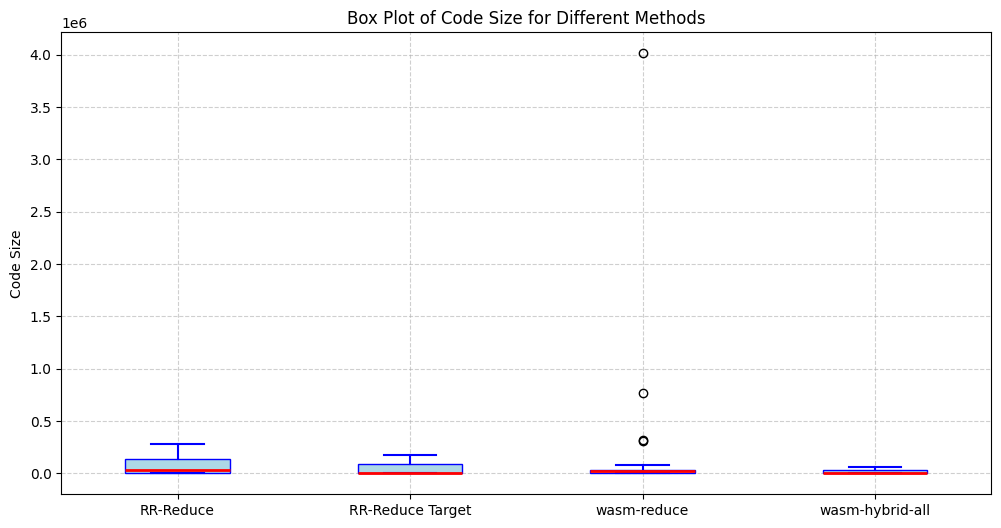

In [72]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# size_to_use = "module-size"
size_to_use = "code-size"

# Collecting code size data
wasm_reduce_sizes = []
wasm_slice_target_sizes = []
wasm_slice_sizes = []
wasm_hybrid_all_sizes = []

test_names = []

for test_name, data in metrics.items():
    try:
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)
        wasm_slice_target_size = data['wasm-slice'].get('target-size')
        wasm_slice_code_size = data['wasm-slice'].get(size_to_use)
        wasm_hybrid_all_code_size = data['wasm-hybrid-all'].get(size_to_use)

        if wasm_reduce_code_size is not None and wasm_slice_target_size is not None and  wasm_slice_code_size is not None and wasm_hybrid_all_code_size is not None:
            test_names.append(test_name)
            wasm_reduce_sizes.append(wasm_reduce_code_size)
            wasm_slice_target_sizes.append(wasm_slice_target_size)
            wasm_slice_sizes.append(wasm_slice_code_size)
            wasm_hybrid_all_sizes.append(wasm_hybrid_all_code_size)
    except Exception as e:
        print(f"Error processing {test_name}: {e}")

# Ensure we have valid numerical data
wasm_reduce_sizes = sorted(wasm_reduce_sizes)
wasm_slice_target_sizes = sorted(wasm_slice_target_sizes)
wasm_slice_sizes = sorted(wasm_slice_sizes)
wasm_hybrid_all_sizes = sorted(wasm_hybrid_all_sizes)
print("Wasm Reduce Sizes:", wasm_reduce_sizes)
print("Wasm Slice Target Sizes:", wasm_slice_target_sizes)
print("Wasm Slice Sizes:", wasm_slice_sizes)
print("Wasm Hybrid All Sizes:", wasm_hybrid_all_sizes)
plt.figure(figsize=(12, 6))

# Create box plots side by side
plt.boxplot([wasm_slice_sizes, wasm_slice_target_sizes, wasm_reduce_sizes, wasm_hybrid_all_sizes],
            vert=True, patch_artist=True,
            labels=['RR-Reduce', 'RR-Reduce Target', "wasm-reduce", "wasm-hybrid-all"],
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=1.5))

plt.ylabel("Code Size")
plt.title("Box Plot of Code Size for Different Methods")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
import json
import tabulate
from scipy.stats import gmean

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Code Size",  "RR-Reduce Code Size", "RR-Reduce Target Size", "wasm-reduce Code Size", "wasm-hybrid Code Size"]

# size_to_use = 'module-size'
size_to_use = 'code-size'

lowest_tool = {}
for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        fixed_by = metadata.get('fixed-by')
        original_code_size = data['metadata'].get(size_to_use)
        rr_reduce_code_size = data['wasm-slice'].get('code-size')
        rr_reduce_target_size = data['wasm-slice'].get('target-size')
        wasm_hybrid_all_code_size = data['wasm-hybrid-all'].get(size_to_use)
        wasm_reduce_code_size = data['wasm-reduce'].get(size_to_use)
        if test_name in ["bullet", "pathfinding"]:
            print(f"Local variables for {test_name}:")
            print(f"original_code_size: {original_code_size}")
            print(f"rr_reduce_code_size: {rr_reduce_code_size}")
            print(f"rr_reduce_target_size: {rr_reduce_target_size}")
            print(f"wasm_hybrid_all_code_size: {wasm_hybrid_all_code_size}")
            print(f"wasm_reduce_code_size: {wasm_reduce_code_size}")

        rr_reduce_code_size_percentage = (rr_reduce_code_size / original_code_size) * 100
        rr_reduce_target_size_percentage = (rr_reduce_target_size / original_code_size) * 100
        wasm_hybrid_all_code_size_percentage = (wasm_hybrid_all_code_size / original_code_size) * 100
        wasm_reduce_code_size_percentage = (wasm_reduce_code_size / original_code_size) * 100
        # Determine the tool with the lowest code size percentage
        min_percentage = min(rr_reduce_code_size_percentage, rr_reduce_target_size_percentage, wasm_reduce_code_size_percentage, wasm_hybrid_all_code_size_percentage)
        lowest_tools = []
        if min_percentage == rr_reduce_code_size_percentage:
            lowest_tools.append('RR-Reduce Code Size')
        if min_percentage == rr_reduce_target_size_percentage:
            lowest_tools.append('RR-Reduce Target Size')
        if min_percentage == wasm_reduce_code_size_percentage:
            lowest_tools.append('wasm-reduce Code Size')
        if min_percentage == wasm_hybrid_all_code_size_percentage:
            lowest_tools.append('wasm-hybrid Code Size')
        lowest_tool[test_name] = ', '.join(lowest_tools)

        table_data.append([
            test_name,
            # fixed_by,
            original_code_size,
            rr_reduce_code_size_percentage,
            rr_reduce_target_size_percentage,
            wasm_reduce_code_size_percentage,
            wasm_hybrid_all_code_size_percentage,
        ])
    except Exception as e:
        print(test_name, data)
        print(e)
        continue
# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the percentages
geomean_rr_reduce = gmean([row[2] for row in table_data])
geomean_rr_reduce_target = gmean([row[3] for row in table_data])
geomean_wasm_hybrid_all = gmean([row[4] for row in table_data])
geomean_wasm_reduce = gmean([row[5] for row in table_data])

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    geomean_rr_reduce,
    geomean_rr_reduce_target,
    geomean_wasm_hybrid_all,
    geomean_wasm_reduce
])

# Add geometric mean to lowest_tool
lowest_tool["Geomean"] = "wasm-hybrid Code Size"

for row in table_data:
    row[2] = f"{row[2]:.2f}\%"
    row[3] = f"{row[3]:.2f}\%"
    row[4] = f"{row[4]:.2f}\%"
    row[5] = f"{row[5]:.2f}\%"

# Make the lowest tool bold in the table
for row in table_data:
    test_name = row[0]
    if test_name in lowest_tool:
        tools = lowest_tool[test_name]
        for tool in tools.split(', '):
            tool_index = headers.index(tool)
            row[tool_index] = f"\\textbf{{{row[tool_index]}}}"

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=".2f")

rq2_table_path = f'./table/rq1.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

bullet {'metadata': {'origin': 'Wasm-R3-Bench', 'engine': 'wizard', 'fixed-by': 'f7aca00', 'path': '/home/doehyunbaek/wasm-r3/evaluation/benchmarks/bullet/bullet.wasm', 'module-size': 688142, 'code-size': 536115}, 'wasm-reduce': {'time': 86400.00287055969, 'module-size': 376869, 'code-size': 363523}, 'wasm-slice': {'time': 86400.00287055969, 'module-size': 37686, 'code-size': 36352}, 'wasm-hybrid-all': {'time': 86400.00287055969, 'module-size': 3768, 'code-size': 3635}}
unsupported operand type(s) for /: 'NoneType' and 'int'
pathfinding {'metadata': {'origin': 'Wasm-R3-Bench', 'engine': 'wizard', 'fixed-by': 'ccf0c56', 'path': '/home/doehyunbaek/wasm-r3/evaluation/benchmarks/pathfinding/pathfinding.wasm', 'module-size': 197113, 'code-size': 180026}, 'wasm-reduce': {'time': 12057.170331716537, 'module-size': 3908, 'code-size': 1023}, 'wasm-slice': {'time': 86400.00287055969, 'module-size': 3908, 'code-size': 1023}, 'wasm-hybrid-all': {'time': 86400.00287055969, 'module-size': 3908, 'cod

<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:81: SyntaxWarning: invalid escape sequence '\%'
<>:82: SyntaxWarning: invalid escape sequence '\%'
<>:83: SyntaxWarning: invalid escape sequence '\%'
<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:81: SyntaxWarning: invalid escape sequence '\%'
<>:82: SyntaxWarning: invalid escape sequence '\%'
<>:83: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1772149/2728393018.py:80: SyntaxWarning: invalid escape sequence '\%'
  row[2] = f"{row[2]:.2f}\%"
/tmp/ipykernel_1772149/2728393018.py:81: SyntaxWarning: invalid escape sequence '\%'
  row[3] = f"{row[3]:.2f}\%"
/tmp/ipykernel_1772149/2728393018.py:82: SyntaxWarning: invalid escape sequence '\%'
  row[4] = f"{row[4]:.2f}\%"
/tmp/ipykernel_1772149/2728393018.py:83: SyntaxWarning: invalid escape sequence '\%'
  row[5] = f"{row[5]:.2f}\%"


In [13]:
import json
from scipy.stats import gmean
import tabulate

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Code Size", "RR-Reduce Time(s)", "wasm-hybrid Time(s)","wasm-reduce Time(s)"]

for test_name, data in metrics.items():
    try:
        metadata = data['metadata']
        # fixed_by = metadata.get('fixed-by')
        original_size = data['metadata'].get('code-size')
        rr_reduce_time = float(data['wasm-slice'].get('time'))
        wasm_hybrid_all_time = float(data['wasm-hybrid-all'].get('time')) + rr_reduce_time
        wasm_reduce_time = float(data['wasm-reduce'].get('time'))
        table_data.append([
            test_name,
            # fixed_by,
            original_size,
            rr_reduce_time,
            wasm_hybrid_all_time,
            wasm_reduce_time
        ])
    except Exception as e:
        print(e)
        continue

# Sort the table data by the original size
table_data.sort(key=lambda row: float(row[1]))

# Calculate geometric mean for the times
geomean_rr_reduce_time = gmean([row[2] for row in table_data])
geomean_wasm_hybrid_all_time = gmean([row[3] for row in table_data])
geomean_wasm_reduce_time = gmean([row[4] for row in table_data])

# Append the geometric mean row
table_data.append([
    "Geomean",
    "",
    geomean_rr_reduce_time,
    geomean_wasm_hybrid_all_time,
    geomean_wasm_reduce_time
])

latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.0f")

rq2_table_path = f'./table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

\begin{tabular}{llrrr}
\hline
 Name          & Input Code Size   &   RR-Reduce Time(s) &   wasm-hybrid Time(s) &   wasm-reduce Time(s) \\
\hline
 wasmedge#3018 & 1913              &                 120 &                   131 &                    15 \\
 wamr#2789     & 17604             &                 245 &                   254 &                   195 \\
 wasmedge#3019 & 19098             &                 121 &                   134 &                   329 \\
 wamr#2862     & 19727             &                 182 &                   215 &                    42 \\
 wamr#2450     & 24482             &                  14 &                    25 &                    29 \\
 wasmedge#3076 & 31365             &               3,600 &                 4,157 &                   537 \\
 mandelbrot    & 64515             &                 137 &                86,537 &                71,808 \\
 wasmedge#3057 & 243564            &                 121 &                   137 &                 